# Batch Propogation of TLEs we obtained from Space Track
In this notebook we will propogate the TLEs we obtained from space track using the sgp4 propogator. However we will make use of the batch propogator that incorporates pytorch methods and tensors to speed up the porpogation process of TLEs

## Dependencies

In [1]:
import json
import pandas as pd
import dsgp4
import numpy as np
import torch

Hello world!


## Read the TLEs from the JSON file and make them into objects

In [2]:
import json
import pandas as pd
import numpy as np
import dsgp4.tle

def raj_TLE_json_to_array_TLE_objects(filename):
    """
    Converts a JSON file of satellite data from Space-Track into an array of TLE objects using dsgp4.tle.TLE().
    
    Parameters:
    ----------------
    filename (str): The JSON file name containing TLE data from Space-Track.
    
    Returns:
    ----------------
    TLE_arr (numpy.ndarray): A numpy array of TLE objects created from the JSON file.
    """
    
    # Read JSON file
    with open(filename, 'r') as file:
        tle_data = json.load(file)
    
    # Convert JSON data to DataFrame for easier manipulation
    df_tle = pd.DataFrame(tle_data)

    # Combine TLE_LINE1 and TLE_LINE2 into a single string for each TLE
    df_tle["TLE"] = df_tle['TLE_LINE1'] + '\n' + df_tle['TLE_LINE2']
    
    # Convert each TLE string to a dsgp4 TLE object and collect them in a list
    TLE_lst = [dsgp4.tle.TLE(tle_str) for tle_str in df_tle['TLE']]
    
    # Convert list to numpy array
    TLE_arr = np.array(TLE_lst)
    
    return TLE_arr

# Example usage
TLE_arr = raj_TLE_json_to_array_TLE_objects('Starlink_Satellites.json')


## Batch Propogation

In [26]:
def raj_batch_propagate(TLE_arr, propagation_time, steps):
    """
    Propagates an array of TLEs and returns the propagated position and velocity vectors.
    
    Parameters:
    ----------------
    TLE_arr (numpy array): Array of TLE objects to propagate.
    propagation_time (int): Total propagation time in minutes.
    steps (int): Number of discrete steps to split the propagation time into.
    
    Returns:
    ----------------
    states_teme (torch.Tensor): Tensor of propagated position and velocity vectors
                                for each TLE across the specified steps.
    """
    
    # Repeat each TLE 'steps' times for propagation
    tles_repeated = []
    for tle in TLE_arr:
        tles_repeated += [tle] * steps
    
    # Generate time steps (same for each TLE)
    tsinces = torch.cat([torch.linspace(0, propagation_time, steps)]*len(TLE_arr))
    
    # Initialize TLEs into a batch
    _, tle_batch = dsgp4.initialize_tle(tles_repeated)
    
    # Propagate the batch
    states_teme = dsgp4.propagate_batch(tle_batch, tsinces)
    
    return states_teme


starlink100_propogated = raj_batch_propagate(TLE_arr[0:100],24*60,1) #propogate first 100 starlink satellites for one day with 10000 steps



# Plot some of the starlink satellites 

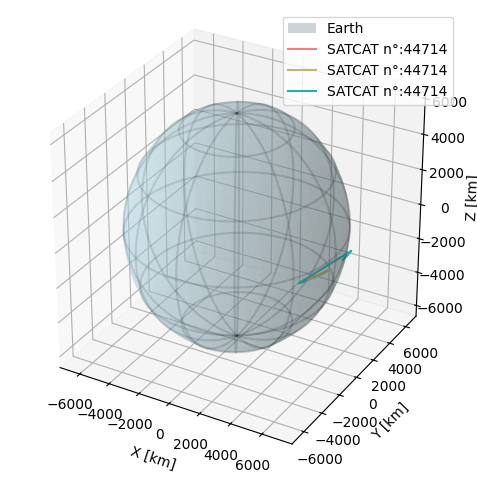

In [27]:
step =10


ax=dsgp4.plot_orbit(starlink100_propogated[0*step:1*step],
                    color='lightcoral',
                    label=f'SATCAT n°:{TLE_arr[0].satellite_catalog_number}')
ax=dsgp4.plot_orbit(starlink100_propogated[1*step:2*step],
                    ax=ax,
                    color='darkkhaki', 
                    label=f'SATCAT n°:{TLE_arr[1].satellite_catalog_number}')
ax=dsgp4.plot_orbit(starlink100_propogated[2*step:3*step],
                    ax=ax, 
                    color='lightseagreen', 
                    label=f'SATCAT n°:{TLE_arr[2].satellite_catalog_number}')

